## This Notebook is tasked with learning the kernel from some pinhole data. 
#### We do it in two stages. First we apply an affine transform model to get the kernel in the right location. Then we make regions of the kernel trainable and do further training. 

In [633]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
from models.custom.modules import *
import forward.fourier.method as fwd

from forward.fourier.kernel_creator import *
import scipy.ndimage
from skimage.transform import rotate

from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass,shift

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")




%load_ext autoreload
%autoreload 2
device = 'cuda:1'

desired_range = [750,850]
desired_channels = 25

4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [634]:
%reload_ext autoreload

## Go from nograting cube to grating cube with grad descent


In [635]:
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20231016_Monochromator/'


mask_nograting_cube = torch.load(dir + 'mask_cube_nograting.pt').to(torch.float32).to(device)

mask_funda_wl = mask_nograting_cube[:,:,100:600,1000:1500]

mask_funda = mask_funda_wl.sum(1).unsqueeze(1)


In [636]:
peaks = peak_local_max(mask_nograting_cube[0,11].cpu().numpy(), min_distance=6,threshold_rel=0.1)

In [637]:
boxsize = 10

wl = mask_nograting_cube.shape[1]

com_peaks = np.zeros((len(peaks),wl,2),dtype=np.float32)
extracted_peaks = np.zeros((len(peaks), wl, boxsize,boxsize))
simulated_peaks = np.zeros_like(extracted_peaks)
simulated_peaks[:,:,boxsize//2-1:boxsize//2+1,boxsize//2-1:boxsize//2+1] =1

kernelsize = 9

psfs = np.zeros((len(peaks),kernelsize,kernelsize))

for l in range(wl):
    for n,peak in enumerate(peaks):
        print(n/len(peaks),l,end='\r')

        extracted_peaks[n,l] = mask_nograting_cube[0,l,peak[0]-boxsize//2:peak[0]+boxsize//2,peak[1]-boxsize//2:peak[1]+boxsize//2].cpu().numpy()
        thresholded = extracted_peaks[n,l].copy()
        thresholded[thresholded<0.05*thresholded.max()] = 0

        com_peaks[n,l] = np.array(center_of_mass(thresholded)) - (boxsize//2  - 0.5)



        simulated_peaks[n,l] = shift(simulated_peaks[n,l],com_peaks[n,l]  ,order=1)  
        simulated_peaks[n,l] *=  extracted_peaks[n,l].mean() / simulated_peaks[n,l].mean()

        com_peaks[n,l] += peak


    # psfs[n] = calc_psf_kernel(extracted_peaks[n],simulated_peaks[n],kernelsize=kernelsize)




3.565780497183368e-07 3.565780497183368e-07


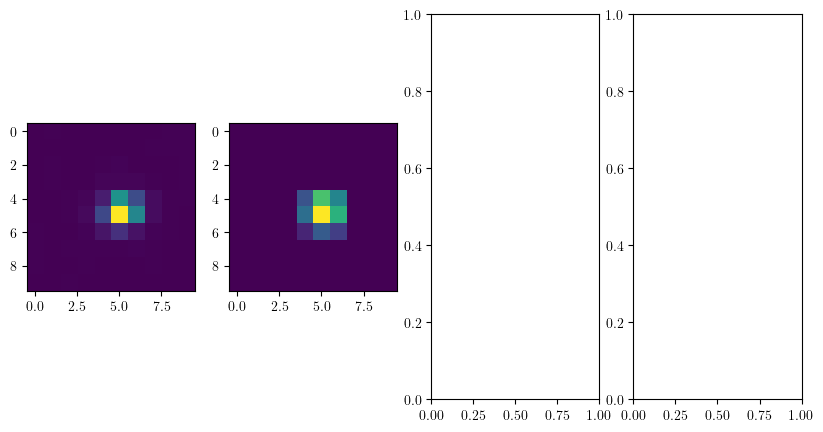

In [638]:
l=11

i = np.random.randint(len(peaks))
fig,ax = plt.subplots(1,4,figsize=(10,5))
ax[0].imshow(extracted_peaks[i,l])
ax[1].imshow(simulated_peaks[i,l])

print(extracted_peaks[i,l].mean(),simulated_peaks[i,l].mean())  


### CoM Training

Lets begin with a map of 2d mask pixels. The model is allowed to rotate them and shift them in order to match the data as best as possible.

In [639]:



peaks = peak_local_max(mask_funda[0,0].cpu().numpy(), min_distance=6,threshold_rel=0.1)

In [640]:
peaks.shape

(1962, 2)

In [641]:
boxsize = 8

from scipy.ndimage import center_of_mass,shift
CoMs = np.zeros((len(peaks),2))
for n,peak in enumerate(peaks):
    print(n/len(peaks),end='\r')
    thresholded = mask_funda[0,0,peak[0]-boxsize//2:peak[0]+boxsize//2+1,peak[1]-boxsize//2:peak[1]+boxsize//2+1].cpu().numpy()

    CoMs[n] = np.array(center_of_mass(thresholded)) - (boxsize//2  - 0.5)

    CoMs[n] += peak

In [642]:
CoMs.shape

(1962, 2)

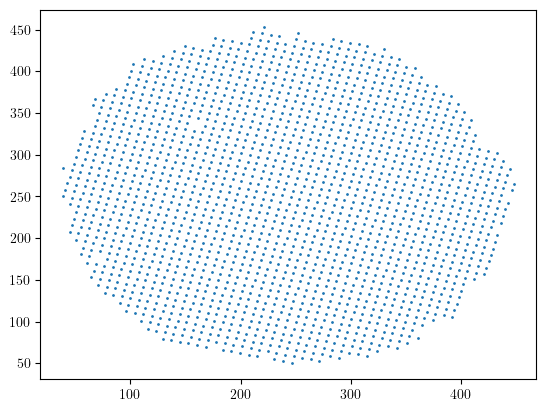

In [643]:
plt.scatter(CoMs[:,1],CoMs[:,0],s=1)    

In [644]:
small_CoMs = CoMs[(CoMs[:,0] > 200 ) & (CoMs[:,0] < 300 ) & (CoMs[:,1] > 200 ) & (CoMs[:,1] < 300 )]

distances = np.zeros((len(small_CoMs),len(small_CoMs)))
for i in range(len(small_CoMs)):
    for j in range(len(small_CoMs)):
        distances[i,j] = np.linalg.norm(small_CoMs[i] - small_CoMs[j])

In [645]:
distances[distances<5] = np.inf

1.3275001697937343 0.004953099201702548


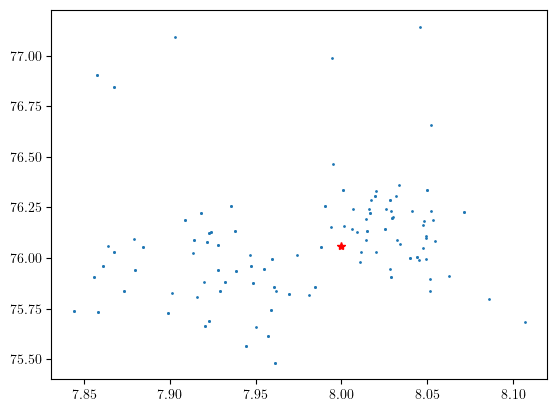

In [646]:
angle = []
distance = []
for i in range(len(small_CoMs)):
    bla = distances[i].argsort()[:1]

    for j in range(1):

        angle.append(np.arctan2((small_CoMs[i,0] - small_CoMs[bla[j],0]) , (small_CoMs[i,1] - small_CoMs[bla[j],1])))
        distance.append(distances[i,bla[j]])

# plt.plot(angle,'*')

angle=np.array(angle)

angle[angle>np.pi/2] -= np.pi/2
angle[angle<0] += np.pi/2
angle[angle<0] += np.pi/2

# plt.plot(angle,'*')

plt.scatter(distance,np.rad2deg(angle),s=1)
print(np.mean(angle),np.std(angle))
plt.plot(8,np.rad2deg(np.mean(angle)),'r*')

angle = np.mean(angle)



In [647]:
np.rad2deg(1.3297773343508286)

76.19062895045943

In [650]:

init_guess = torch.zeros((1,1,int(mask_funda.shape[2]),int(mask_funda.shape[3])),dtype=torch.float32,device=device)
# init_guess = torch.zeros((1,1,int(mask_funda.shape[2] * 2),int(mask_funda.shape[3] * 2)),dtype=torch.float32,device=device)

# peaks = peaks[::3]
# CoMs = CoMs[::3]

peak = peaks[0]

i,j = peak
while i > 0:
    while j>0:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j -= 8
    j = peak[1]
    while j < init_guess.shape[-1]:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j += 8
    j = peak[1]


    i -= 8

i,j = peak
while i < init_guess.shape[-2]:
    while j>0:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j -= 8
    j = peak[1]
    while j < init_guess.shape[-1]:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j += 8
    j = peak[1]
    i += 8

# init_guess[:,:,peaks[0,0] - 1:peaks[0,0]+1,peaks[0,1]-1:peaks[0,1]+1] = 1

In [651]:
kernelsize = 9

regions = np.zeros((len(small_CoMs),2,2))

regions[:,0,0] = (small_CoMs[:,0] - kernelsize//2).astype(int)
regions[:,0,1] = (small_CoMs[:,0] + kernelsize//2).astype(int)
regions[:,1,0] = (small_CoMs[:,1] - kernelsize//2).astype(int)
regions[:,1,1] = (small_CoMs[:,1] + kernelsize//2).astype(int)

# regions[:,0] = regions[:,0] - 100
# regions[:,1] = regions[:,1] - 1000

regions = torch.tensor(regions,dtype=torch.int)



In [657]:
angle = (angle - np.pi/2)

In [675]:
# loss_fn = CenterOfMassLoss(regions,funda_weight=1,intensity_factor=2, channels=mask_grating_cube.shape[1])
CoMLoss = CenterOfMassLoss(regions,funda_weight=1,intensity_factor=1, channels=1)

# model = AffineTransformModel(region = regions,rot = 45.,transX=0.,transY=0.,scale = True, no_channels = 1).to(device)
model = AffineTransformModel(region = np.array([[[0,init_guess.shape[2]],[0,init_guess.shape[3]]]]),rot = -np.rad2deg(angle),transX=0.08,transY=0.08,scale = False, no_channels = 1, grating=False).to(device)

In [676]:
init_guess = init_guess.to(device)

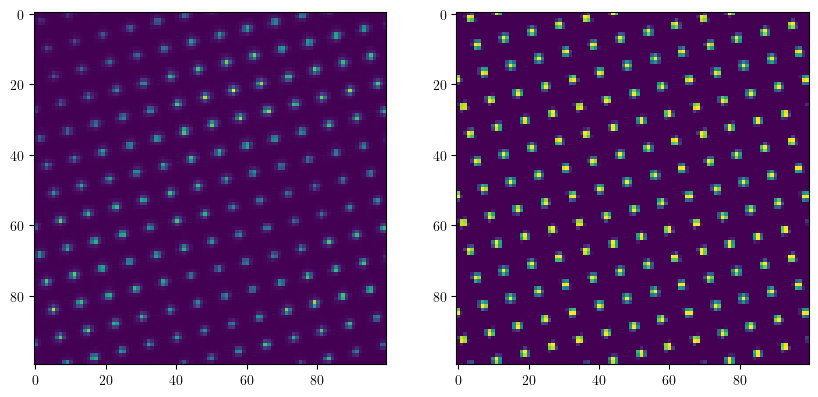

In [677]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(mask_funda_wl.cpu()[0,11,100:200,100:200])

ax[1].imshow(model(init_guess).detach().cpu()[0,0,100:200,100:200])

In [678]:
# init_guess += 0.0001*torch.rand_like(init_guess)

In [679]:
model(init_guess).shape

torch.Size([1, 1, 500, 500])

In [680]:
yhat = model(init_guess)

shape = mask_funda.shape[2:]

#take center of yhat according to shape
# yhat = yhat[:,:,yhat.shape[2]//2-shape[0]//2:yhat.shape[2]//2+shape[0]//2,yhat.shape[3]//2-shape[1]//2:yhat.shape[3]//2+shape[1]//2]

CoMLoss(yhat,mask_funda_wl[:,11:12]).item()

5.386183261871338

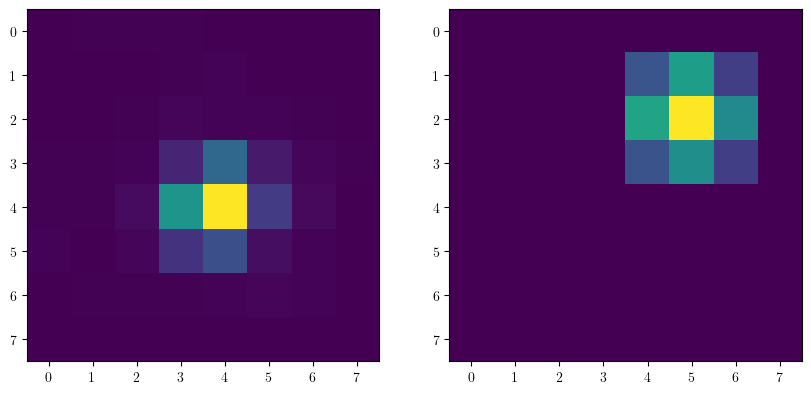

In [681]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

peak = peaks[0]
ax[0].imshow(mask_funda_wl.cpu()[0,11,peak[0]-boxsize//2:peak[0]+boxsize//2,peak[1]-boxsize//2:peak[1]+boxsize//2])
ax[1].imshow(yhat.detach().cpu()[0,0,peak[0]-boxsize//2:peak[0]+boxsize//2,peak[1]-boxsize//2:peak[1]+boxsize//2])

In [682]:
x = init_guess.to(device)
y = mask_funda_wl[:,11:12] * x.mean() / mask_funda_wl[:,11:12].mean()
y = y.to(device)

In [683]:
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['mse'] = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

epochs = 300
start_time_sec = time.time()
num_train_examples = 1

for epoch in range(1, epochs+1):
    torch.cuda.empty_cache()


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()


    adjusted = model(x)
    # adjusted = model(mask_funda)
    # adjusted = yhat[:,:,yhat.shape[2]//2-shape[0]//2:yhat.shape[2]//2+shape[0]//2,yhat.shape[3]//2-shape[1]//2:yhat.shape[3]//2+shape[1]//2]

    
    
    # loss =  loss_fn(adjusted, init_guess)
    loss =  CoMLoss(adjusted, y)

    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() 





    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}: , train loss: {(train_loss/num_train_examples):5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['loss'].append(train_loss)


KeyboardInterrupt: 

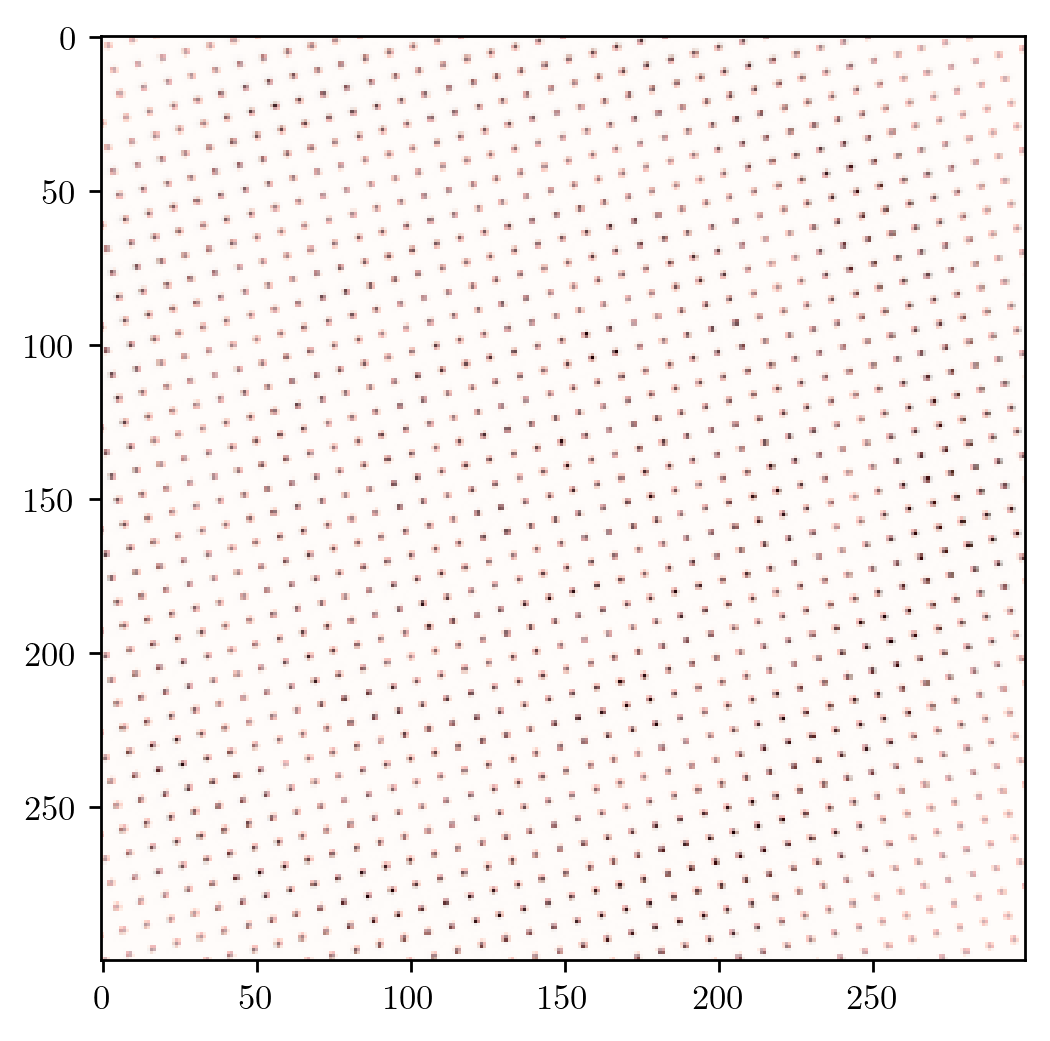

In [761]:
plt.figure(dpi=250)

plt.imshow(y[0,0,100:400,100:400].cpu().detach(),cmap='Greys')
plt.imshow(adjusted[0,0,100:400,100:400].cpu().detach(),alpha=0.3,cmap='Reds')

In [939]:
model2 = AffineTransformModel(region = np.array([[[0,init_guess.shape[2]],[0,init_guess.shape[3]]]]),rot = -np.rad2deg(angle),transX=0.06,transY=0.08,scale = True, no_channels = 1, grating=False).to(device)


theta = model.fill_theta()[0,0].cpu().detach()
theta_inv = torch.inverse(torch.concat((theta,torch.tensor([0,0,1]).unsqueeze(0)),0))[:2]
# theta_inv = torch.inverse(theta)
# theta_inv[0,2] = -model.transX_list[0]
# theta_inv[1,2] = -model.transY_list[0]

model2.set_theta(theta_inv.unsqueeze(0))

inverse_y = model2(y)

/home/s/Sunny.Howard/SCI/models/custom/model.py:456: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.transX_list = nn.Parameter(torch.tensor(theta[:,0,2]))
/home/s/Sunny.Howard/SCI/models/custom/model.py:457: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.transY_list = nn.Parameter(torch.tensor(theta[:,1,2]))
/home/s/Sunny.Howard/SCI/models/custom/model.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.scaleX_list = nn.Parameter(torch.tensor(theta[:,0,:2]))
/home/s/Sunny.Howard/SCI/models/custom/model.py:459: UserWarning: 

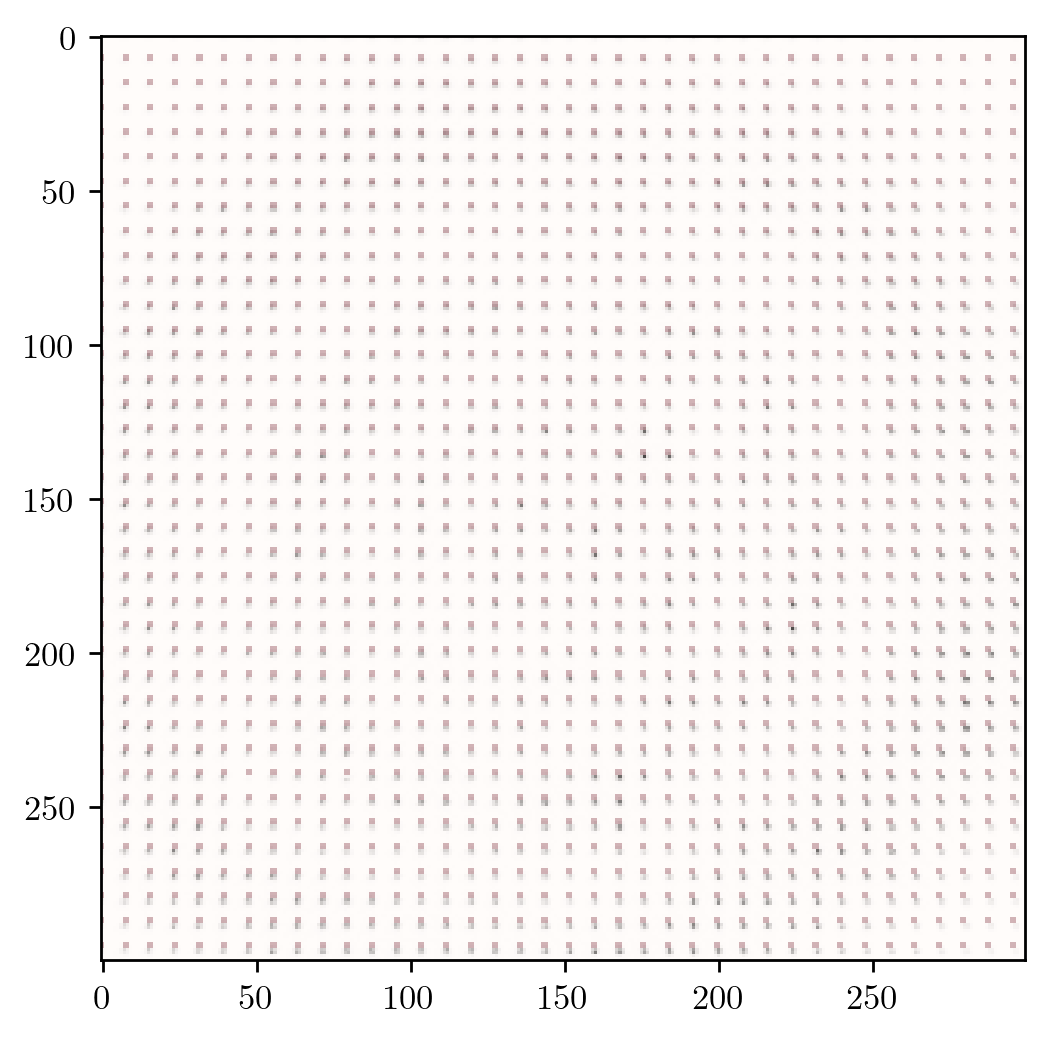

In [940]:
plt.figure(dpi=250)

plt.imshow(inverse_y[0,0,100:400,100:400].cpu().detach(),cmap='Greys')
plt.imshow(x[0,0,100:400,100:400].cpu().detach(),alpha=0.3,cmap='Reds')

In [941]:
intensity_mask = torch.zeros((1,1,int(np.ceil(500/8)),int(np.ceil(500/8)))).to(device)#)torch.zeros_like(affine_guess)
for i in range(500//8):
    for j in range(500//8):
        intensity_mask[:,:,i,j] = inverse_y[:,:,i*8:i*8+8,j*8:j*8+8].sum()/4

up_intensity_mask = torch.nn.functional.interpolate(intensity_mask,scale_factor=8,mode='nearest')[:,:,:500,:500]


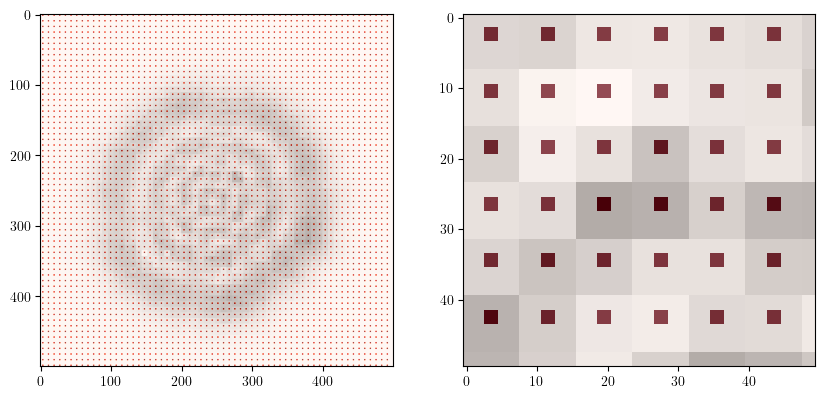

In [827]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(init_guess[0,0].cpu(),cmap='Reds')
ax[0].imshow(up_intensity_mask[0,0].cpu().detach(),alpha=0.3,cmap='Greys')
ax[1].imshow(init_guess[0,0,200:250,200:250].cpu(),cmap='Reds')
ax[1].imshow(up_intensity_mask[0,0,200:250,200:250].cpu().detach(),alpha=0.3,cmap='Greys')


(100.0, 250.0)

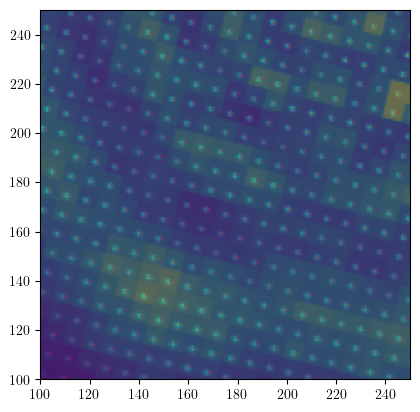

In [828]:
plt.imshow(model(up_intensity_mask)[0,0,].cpu().detach())
# plt.imshow(model(init_guess)[0,0,100:200,100:200].cpu().detach(),alpha=0.5)
plt.imshow(y[0,0,].cpu().detach(),alpha=0.5)
plt.scatter(CoMs[:,1],CoMs[:,0],s=.3,alpha=0.5,c='r')

plt.xlim(100,250)
plt.ylim(100,250)

In [829]:
affine_guess = model(up_intensity_mask * x)

# affine_guess *= mask

print('loss',nn.MSELoss()(affine_guess,y))

theta = model.fill_theta()[0]

grid = nn.functional.affine_grid(theta,init_guess.shape)

torch.save(grid,dir+'affine_grid.pt')

loss tensor(0.0341, device='cuda:1', grad_fn=<MseLossBackward0>)


/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [919]:
#test if intensity worked. 
peaks = peak_local_max(y[0,0].cpu().detach().numpy(), min_distance=6,threshold_rel=0.1)
boxsize=8

diffs = []

for peak in peaks:
    true_mean = y[0,0,peak[0]-boxsize//2:peak[0]+boxsize//2+1,peak[1]-boxsize//2:peak[1]+boxsize//2+1].mean()
    pred_mean = affine_guess[0,0,peak[0]-boxsize//2:peak[0]+boxsize//2+1,peak[1]-boxsize//2:peak[1]+boxsize//2+1].mean()

    diffs.append((true_mean - pred_mean).detach().cpu().numpy())
    

(array([  6.,  41., 238., 453., 464., 479., 251.,  74.,   8.,   4.]),
 array([-0.08729972, -0.06758657, -0.04787342, -0.02816027, -0.00844712,
         0.01126603,  0.03097918,  0.05069232,  0.07040548,  0.09011862,
         0.10983177]),
 <BarContainer object of 10 artists>)

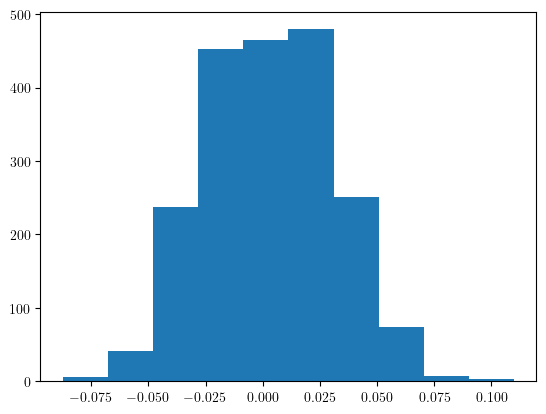

In [920]:
plt.hist(diffs)

In [917]:
torch.tensor(diffs).mean(), torch.tensor(diffs).std(), y.max()

(tensor(0.0031), tensor(0.0278), tensor(4.4746, device='cuda:1'))

In [830]:
print(f'original: {-angle};     final: {model.rot_list.data[0].cpu().numpy()},' )

TypeError: bad operand type for unary -: 'list'

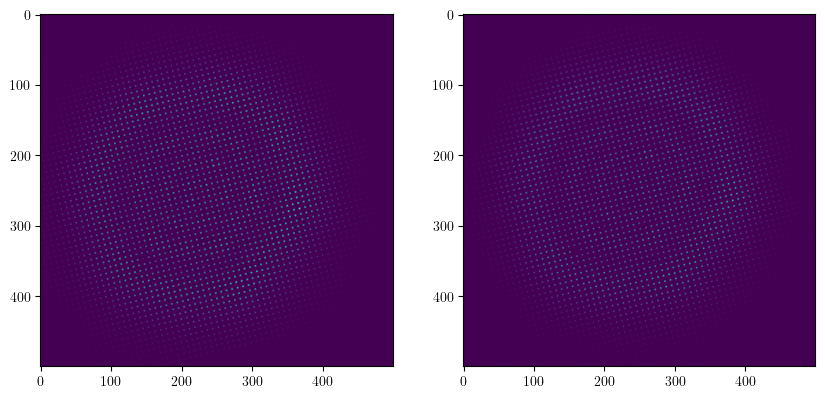

In [831]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow((affine_guess).detach().cpu()[0,0])
ax[1].imshow(y.detach().cpu()[0,0])

#### Now we make grid trainable along with additional warp mask

In [832]:
def hessian(map,norm=2):
    deriv_xx = (1/90)*torch.roll(map,3,dims=2) -(3/20)*torch.roll(map,2,dims=2) + (3/2)*torch.roll(map,1,dims=2) - (49/18) * map + (3/2)*torch.roll(map,-1,dims=2) - (3/20)*torch.roll(map,-2,dims=2) + (1/90)*torch.roll(map,-3,dims=2)
    deriv_yy = (1/90)*torch.roll(map,3,dims=3) -(3/20)*torch.roll(map,2,dims=3) + (3/2)*torch.roll(map,1,dims=3) - (49/18) * map + (3/2)*torch.roll(map,-1,dims=3) - (3/20)*torch.roll(map,-2,dims=3) + (1/90)*torch.roll(map,-3,dims=3)
    deriv_xy = (1/90)*torch.roll(map,(3,3),dims=(2,3)) -(3/20)*torch.roll(map,(2,2),dims=(2,3)) + (3/2)*torch.roll(map,(1,1),dims=(2,3)) - (49/18) * map + (3/2)*torch.roll(map,(-1,-1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,-2),dims=(2,3)) + (1/90)*torch.roll(map,(-3,-3),dims=(2,3))
    deriv_yx = (1/90)*torch.roll(map,(3,-3),dims=(2,3)) -(3/20)*torch.roll(map,(2,-2),dims=(2,3)) + (3/2)*torch.roll(map,(1,-1),dims=(2,3)) - (49/18) * map + (3/2)*torch.roll(map,(-1,1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,2),dims=(2,3)) + (1/90)*torch.roll(map,(-3,3),dims=(2,3))

    deriv_xx = deriv_xx[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_yy = deriv_yy[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_xy = deriv_xy[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_yx = deriv_yx[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)

    all_derivs = torch.concat([deriv_xx,deriv_xy,deriv_yx,deriv_yy],dim=0)

    reg_loss = torch.norm(all_derivs,p=norm) / all_derivs.numel()
    return reg_loss
peaks = peak_local_max(mask_funda_wl[0,11].cpu().numpy(), min_distance=6,threshold_rel=0.1)


In [944]:
lr = 1e-4

history2 = {'tl':[],'mse':[],'reg':[], 'lr':[]}


# Load the affine grid and move it to the device
affine_grid = torch.load(dir+'affine_grid.pt').to(device).detach()

shape = affine_grid.shape

upsample_factor = 2

x_pos = torch.linspace(1, -1, init_guess.shape[2]//upsample_factor)
y_pos = torch.linspace(-1, 1, init_guess.shape[3]//upsample_factor)
x_grid, y_grid = torch.meshgrid(x_pos, y_pos)

init = torch.concat([x_grid.unsqueeze(-1), y_grid.unsqueeze(-1)], dim=-1).unsqueeze(0) * 4 / init_guess.shape[2] #the factor means four pixel shift across image.
init = torch.rand_like(init) * 0.01

# Create spatial_warp, move it to the device, then wrap in nn.Parameter
spatial_warp = (init).to(device)
spatial_warp = nn.Parameter(spatial_warp, requires_grad=True)

# Move affine_grid to the device, then wrap in nn.Parameter
affine_grid = affine_grid.to(device)
affine_grid = nn.Parameter(affine_grid, requires_grad=True)

intensity_mask = intensity_mask.to(device)
intensity_mask = nn.Parameter(intensity_mask, requires_grad=True)

conv = nn.Conv2d(1,1,kernel_size=5,padding=2,bias=False).to(device)

shape = y.shape[2:]

epochs = 40000
init_reg_factor =  4e3

wl = 11
# loss_fn = CoMLoss
loss_fn = torch.nn.MSELoss()

up_intensity_mask = nn.functional.interpolate(intensity_mask,scale_factor=8,mode='nearest').to(device)[:,:,:500,:500]
yhat = nn.functional.grid_sample(x * up_intensity_mask, affine_grid) #  * mask

print(loss_fn(yhat ,y))

all_params = [spatial_warp,] + list(conv.parameters())#,intensity_mask] #affine_grid

optimizer = torch.optim.Adam(all_params, lr=lr)


tensor(0.0341, device='cuda:1', grad_fn=<MseLossBackward0>)


/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [945]:

start_time_sec = time.time()
num_train_examples = 1

for epoch in range(1, epochs+1):
    torch.cuda.empty_cache()


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()
    
    upsampled_warp = nn.functional.interpolate(spatial_warp.permute(0,3,1,2),(spatial_warp.shape[1]*upsample_factor,spatial_warp.shape[2]*upsample_factor),mode='nearest')[...,:x.shape[2],:x.shape[3]].permute(0,2,3,1)
    up_intensity_mask = nn.functional.interpolate(intensity_mask,scale_factor=8,mode='nearest')[:,:,:500,:500]
    newgrid = affine_grid + upsampled_warp


    yhat = nn.functional.grid_sample(x* up_intensity_mask, newgrid)  # * mask

    yhat = conv(yhat)

    reg =   hessian(spatial_warp.permute(0,3,2,1),norm=2) 
    # reg =   hessian(spatial_warp,norm=1) + hessian(affine_grid,norm=1) #+ hessian(intensity_map,norm=1) * 100
# 
    
    mse = loss_fn(yhat, y)
    loss =  mse + init_reg_factor*reg

    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() 

    with torch.no_grad():

        conv.weight.data = torch.clamp(conv.weight.data,0,1)





    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')



    history2['mse'].append(mse.data.item())
    history2['reg'].append((init_reg_factor*reg).data.item())

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


KeyboardInterrupt: 

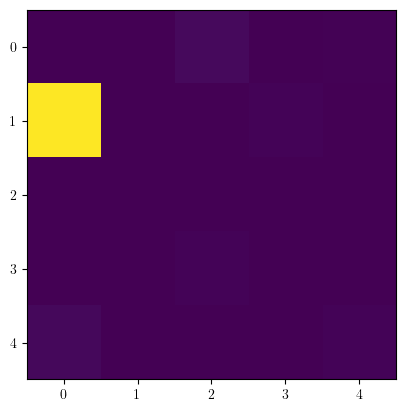

In [948]:
plt.imshow(conv.weight.data[0,0].cpu().detach())

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


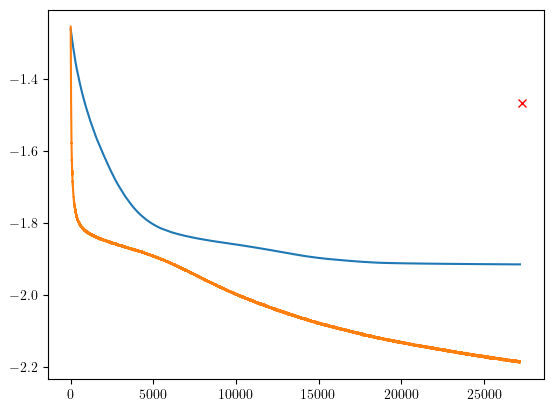

In [949]:
plt.plot(np.log10(history2['mse'][100:]))#[100:])
plt.plot(np.log10(history2['reg'][100:]))#[100:])



yhat_affine = nn.functional.grid_sample(x * up_intensity_mask, affine_grid)  # * mask
mse = loss_fn(yhat_affine, y)


plt.plot(len(history2['mse']),np.log10(mse.data.item()),'rx')#[100:])

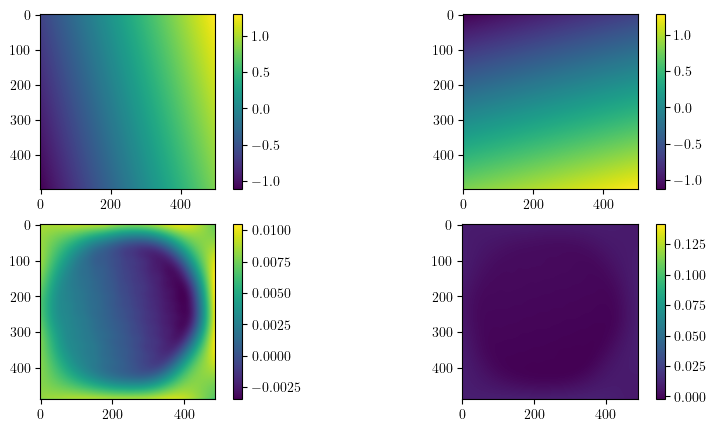

In [923]:
fig,ax = plt.subplots(2,2,figsize=(10,5))
plot1 = ax[0,0].imshow(affine_grid.cpu()[0,...,0].detach())
plt.colorbar(plot1,ax=ax[0,0])
plot2 = ax[0,1].imshow(affine_grid.cpu()[0,...,1].detach())
plt.colorbar(plot2,ax=ax[0,1])


plot3 = ax[1,0].imshow((upsampled_warp).cpu()[0,3*upsample_factor:-3*upsample_factor,3*upsample_factor:-3*upsample_factor,0].detach())
plt.colorbar(plot3,ax=ax[1,0])
plot4 = ax[1,1].imshow((upsampled_warp).cpu()[0,3*upsample_factor:-3*upsample_factor,3:-3*upsample_factor,1].detach())
plt.colorbar(plot4,ax=ax[1,1])

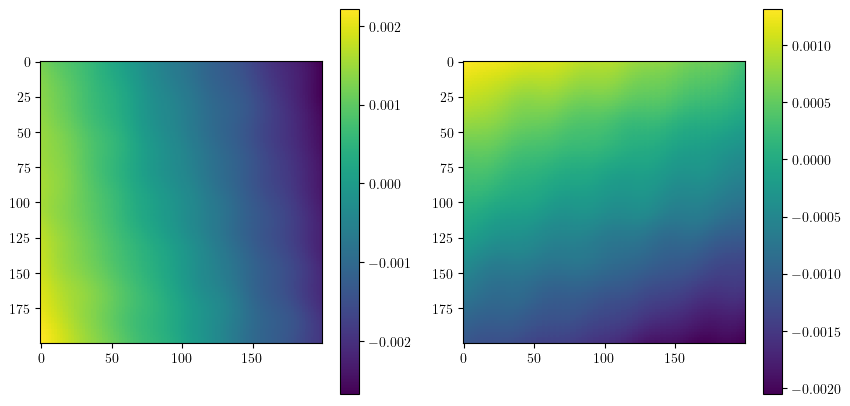

In [924]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
plot3 = ax[0].imshow(upsampled_warp.cpu()[0,150:350,150:350,0].detach())
plt.colorbar(plot3,ax=ax[0])
plot4 = ax[1].imshow(upsampled_warp.cpu()[0,150:350,150:350,1].detach())
plt.colorbar(plot4,ax=ax[1])

In [925]:
yhat.mean(), y.mean()

(tensor(0.0533, device='cuda:1', grad_fn=<MeanBackward0>),
 tensor(0.0625, device='cuda:1'))

tensor(0.0259, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.0067, device='cuda:1', grad_fn=<MseLossBackward0>)


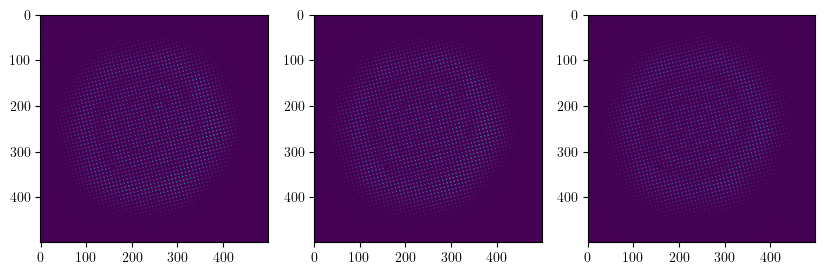

In [926]:
print(loss_fn(yhat_affine ,y))
print(loss_fn(yhat ,y))

fig,ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow((yhat_affine)[0,0].cpu().detach())
ax[1].imshow(yhat[0,0].cpu().detach())
ax[2].imshow(y[0,0].cpu().detach())

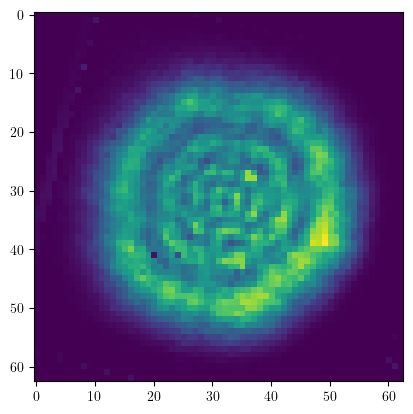

In [927]:
plt.imshow(intensity_mask[0,0].cpu().detach())

In [928]:
# wl=25
# final_prediction = torch.zeros_like(yhat).tile(1,wl,1,1)

# bord = 4

# for l in range(25):
#     for peak in peaks:
#         synthetic = yhat[0,0,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord].detach().cpu()
#         true = mask_funda_wl[0,l,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord].detach().cpu()
#         final_prediction[:,l,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord] = synthetic   *   ( true.sum() / 4)#synthetic.sum())

Text(0.5, 1.0, '$\\mathbf{u} - \\mathbf{f}$')

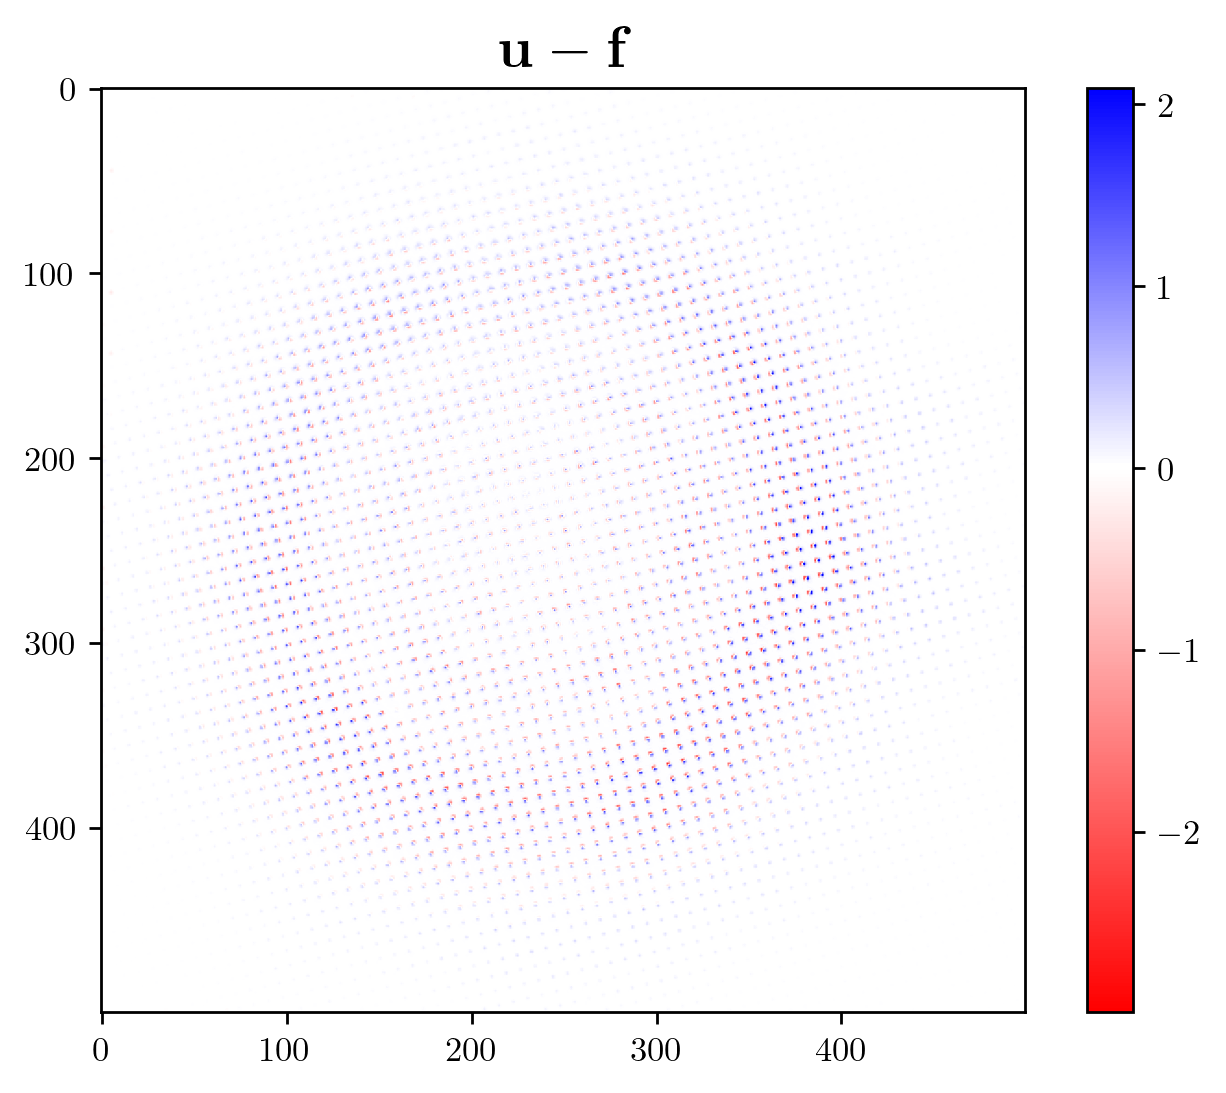

In [929]:

from scipy.ndimage import gaussian_filter


smoothed_truth = torch.tensor(gaussian_filter(y.cpu().detach().numpy(),sigma=20)).to(device)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"

})

plt.figure(dpi=250)
import matplotlib


red = np.array([1,0,0])
white = np.array([1,1,1])
blue = np.array([0,0,1])

colors = []
for i in np.linspace(0,1,100):
    colors.append(  (1-i) * red + (i) * white)             
for i in np.linspace(0,1,70):
    colors.append(  (1-i) * white + (i) * blue)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", colors)




diff = ((y[0,0] - yhat_affine[0,0])).detach().cpu().numpy()

vmax_diff = np.abs(diff).max()



plt.imshow(diff,cmap=cmap,vmax = vmax_diff*0.7,vmin=-vmax_diff); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{f}$',fontsize=17)

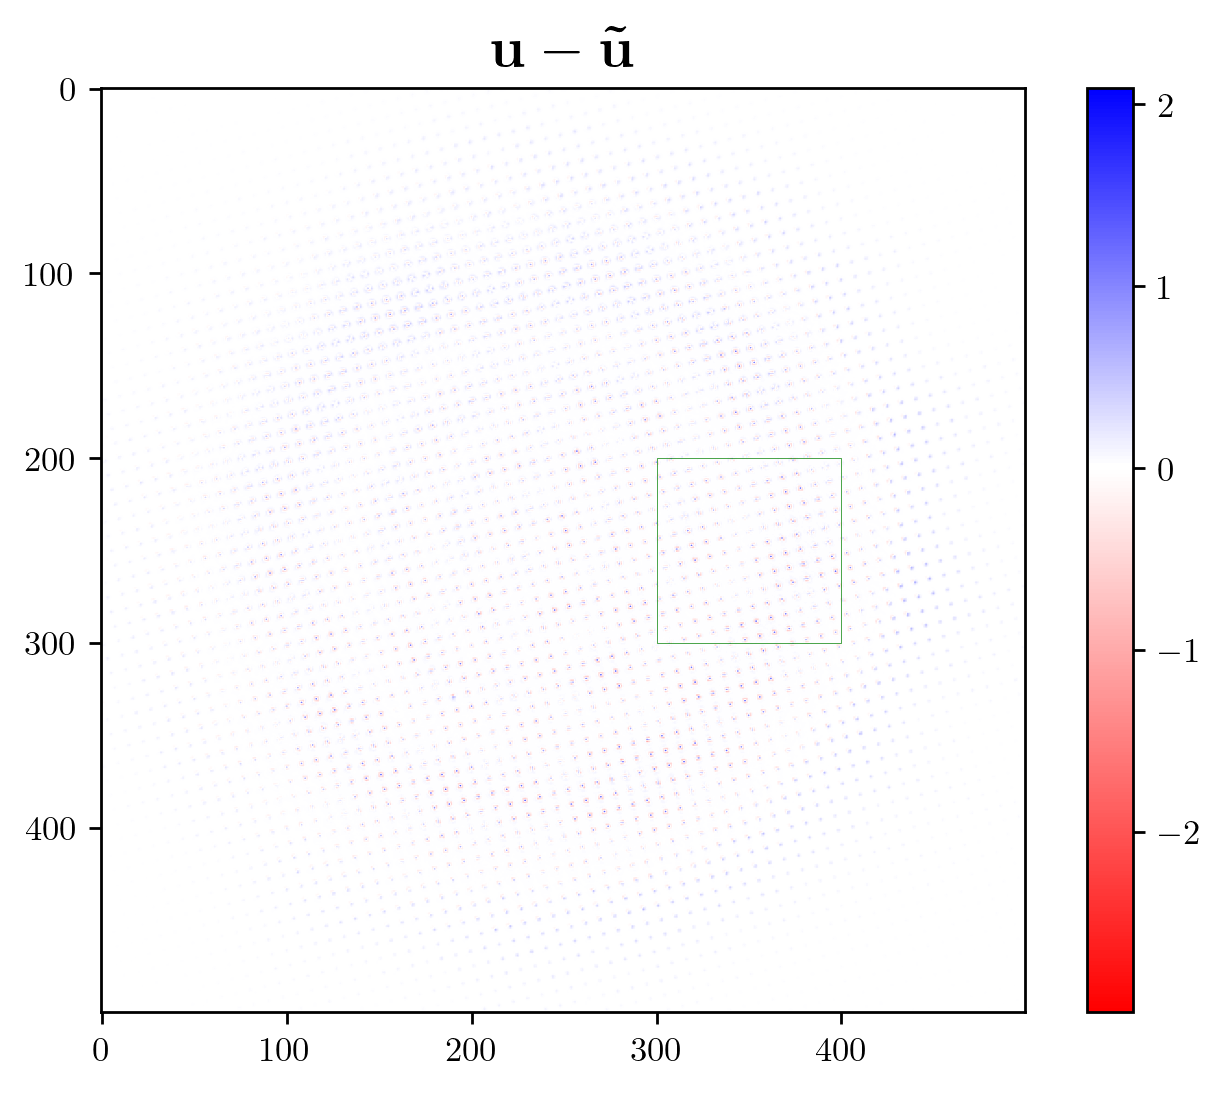

In [930]:
#import patches from matplotlib



from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle


smoothed_truth = torch.tensor(gaussian_filter(y.cpu().detach().numpy(),sigma=20)).to(device)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.figure(dpi=250)
import matplotlib



diff = ((y[0,0] - yhat[0,0])).detach().cpu().numpy()

# vmax_diff = np.abs(diff).max()
#import patches



plt.imshow(diff,cmap=cmap,vmax = vmax_diff*0.7,vmin=-vmax_diff); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\tilde{u}}$',fontsize=17)
# plt.imshow(diff,cmap='RdBu',vmax = vmax_diff,vmin=-vmax_diff); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\tilde{u}}$',fontsize=17)
rect = Rectangle((300, 200), 100, 100, linewidth=0.2, edgecolor='g', facecolor='none')
plt.gca().add_patch(rect)


Text(0.5, 1.0, '$\\mathbf{u} - \\mathbf{\\tilde{u}}$')

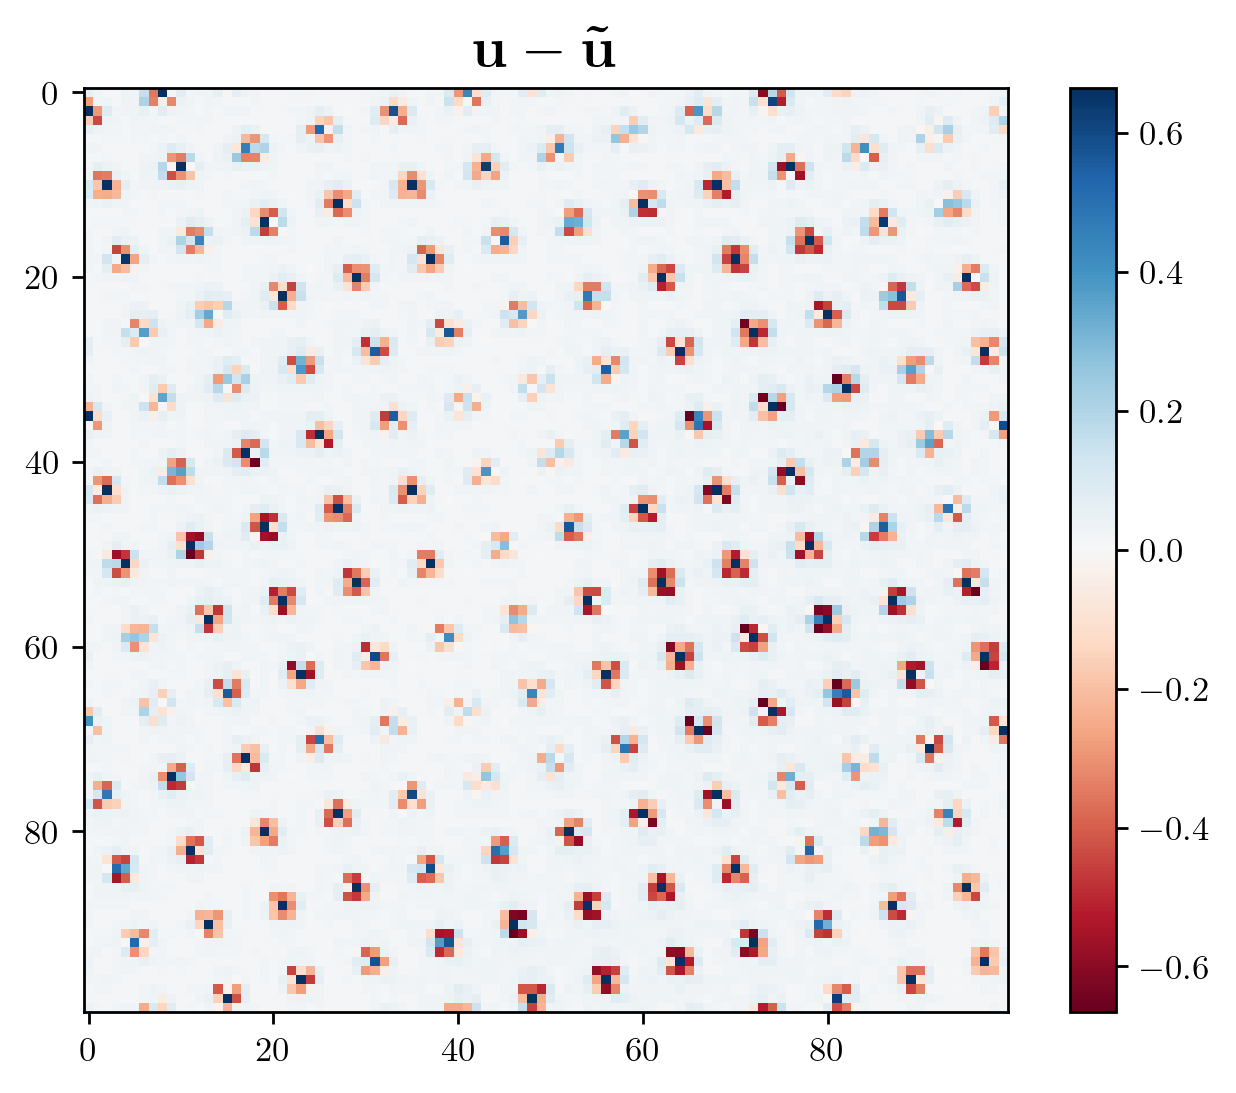

In [931]:
from scipy.ndimage import gaussian_filter

plt.figure(dpi=250)

vmax = abs(diff[200:300,300:400]).max()

plt.imshow(diff[200:300,300:400],cmap='RdBu',vmax = vmax*0.5,vmin=-vmax*0.5); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\tilde{u}}$',fontsize=17)


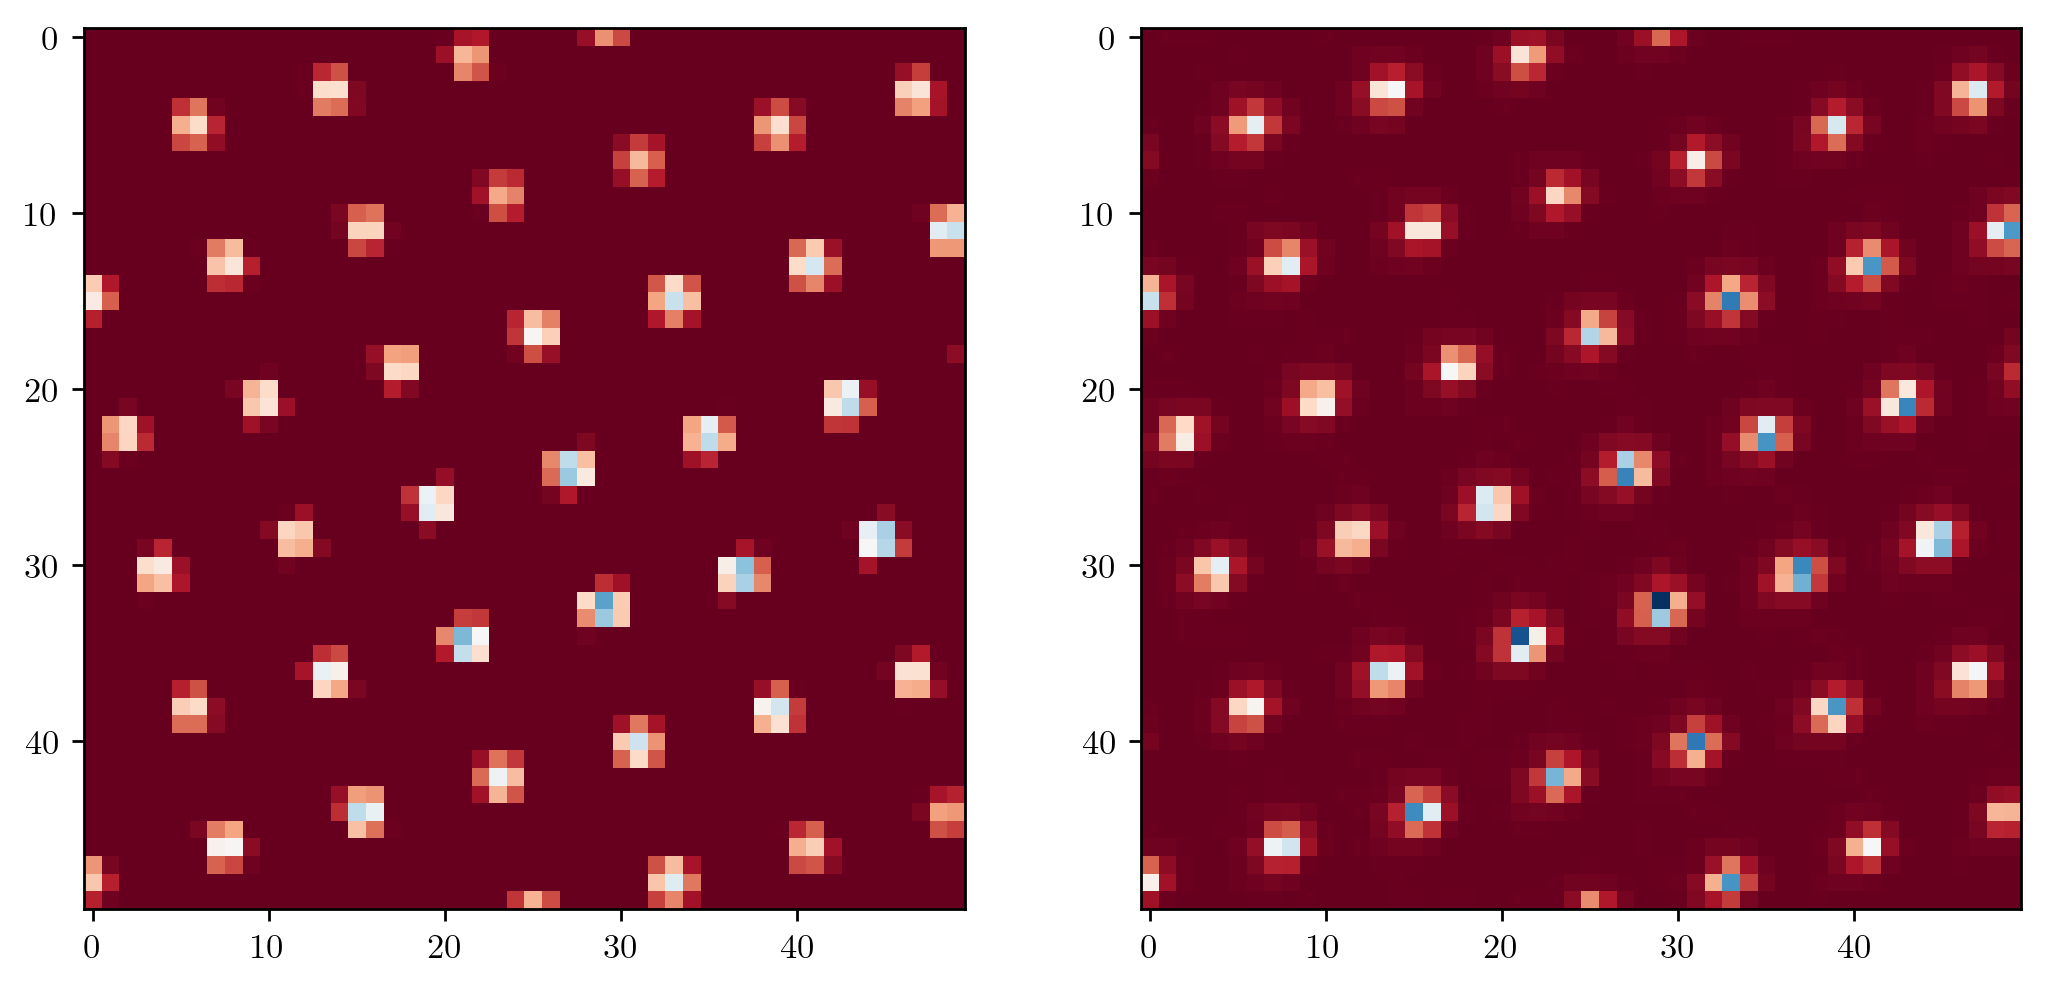

In [932]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=250)

vmax = y[0,0,150:200,150:200].cpu().detach().max()

ax[0].imshow((yhat)[0,0,150:200,150:200].cpu().detach(),vmax=vmax,cmap='RdBu')
ax[1].imshow(y[0,0,150:200,150:200].cpu().detach(),vmax=vmax,cmap='RdBu')
# rect = Rectangle((30, 0), 10, 10, linewidth=0.3, edgecolor='k', facecolor='none')
# ax[0].add_patch(rect)
# ax[1].add_patch(rect)
plt.show()

In [951]:
y[0,0,179:187,175:183].cpu().detach().max()/y[0,0,179:187,175:183].cpu().detach().min()

tensor(688.8660)

tensor(3.1215) tensor(0.1677) tensor(0.2908)
tensor(2.3965) tensor(0.1502) tensor(0.2492)


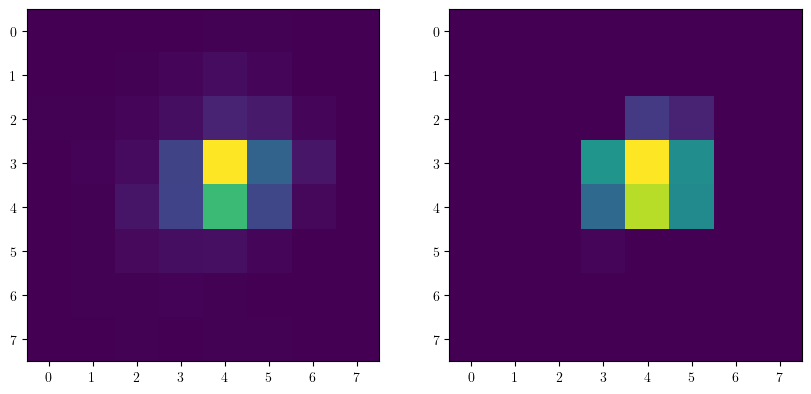

In [933]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(y[0,0,179:187,175:183].cpu().detach())
ax[1].imshow(yhat[0,0,179:187,175:183].cpu().detach())

print(y[0,0,179:187,176:184].cpu().detach().max(), y[0,0,179:187,176:184].cpu().detach().mean(), y[0,0,179:187,176:184].cpu().detach().max()/y[0,0,179:187,176:184].cpu().detach().sum())
print(yhat[0,0,179:187,176:184].cpu().detach().max(), yhat[0,0,179:187,176:184].cpu().detach().mean(), yhat[0,0,179:187,176:184].cpu().detach().max()/yhat[0,0,179:187,176:184].cpu().detach().sum())

(tensor(1.), tensor(0.2500))

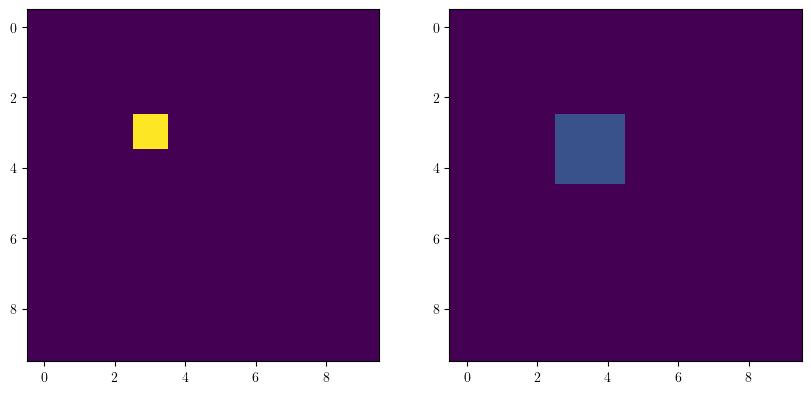

In [888]:
nx,ny = 10,10
a = torch.zeros((nx,ny))
a[3,3] = 1

px_space = 2/nx

xx = torch.linspace(-1 + px_space/2,1 - px_space/2,nx)
yy = torch.linspace(-1 + px_space/2,1 - px_space/2,ny)
# yy = torch.linspace(-1,1,ny)
xx,yy = torch.meshgrid(xx,yy)
grid = torch.cat((xx.unsqueeze(-1),yy.unsqueeze(-1)),dim=-1).unsqueeze(0).to(torch.float32)

grid-= px_space*0.5


final = F.grid_sample(a.unsqueeze(0).unsqueeze(0),grid)

fig,ax = plt.subplots(1,2,figsize=(10,5))

vmax, vmin = a.max(), a.min()

ax[0].imshow(a)
ax[1].imshow(final[0,0],vmax=vmax,vmin=vmin)

a.max(),final.max()